# Notebook Description

This notebook is concerned with the linear regression of the number of days in each of the MJO subphases with the number of raindays each wet season and the total amount of rainfall. This is showing the relatinship between the increasing trend of days in MJO phases 5 and 6 and the increasing rainfal trend in the north west.

**Data**

The data used in this notebook is the AWAP data set and also measurement of the RMM from BOM.

# Packages

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
from importlib import reload
import sys, os

import plotting_functions as pf
import load_dataset as load
import miscellaneous
import phase_calc_functions as phase_calc
import calculation_functions
import constants

import warnings
warnings.filterwarnings('ignore')

image_dir = constants.IMAGE_SAVE_DIR

# Data

In [2]:
# Loading awap
awap = load.load_awap()
awap_ws = phase_calc.wet_season_year(awap)

# Loading RMM
rmm = load.load_rmm()
rmm_ws = phase_calc.wet_season_year(rmm)

awap_ws, rmm_ws = calculation_functions.match_dataset_time(awap_ws, rmm_ws)

awap_ws = miscellaneous.apply_masks(awap_ws)

New datasets are now of lenght d1 = 5567 and d2 = 5567


In [3]:
days_in_each_wet_season = 121 #rmm_ws.amplitude.resample(time='Y').count()
# NOte: Can do this precisly. But for the current dataset, everything is 121

In [4]:
# The number of raindays and total rainfall each wet monsono.
awap_count = calculation_functions.resample_count(awap_ws)
awap_sum = calculation_functions.resample_sum(awap_ws)

awap_int = awap_sum/awap_count

awap_count

<xarray.Dataset>
Dimensions:  (year: 48, lat: 80, lon: 161)
Coordinates:
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
  * lon      (lon) float64 113.5 113.8 114.0 114.2 ... 152.8 153.0 153.2 153.5
  * year     (year) int64 1974 1975 1976 1977 1978 ... 2017 2018 2019 2020 2021
Data variables:
    precip   (year, lat, lon) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    Information:  Only contains the wet season [10,11,12,1,2,3],rainfall >= 1...
    History:      AGCD Regrid on the 11th of June 2021 from /g/data/rr5 by ab...

In [5]:
trend_count_ds = phase_calc.calculate_trend_and_pvalue(awap_count.precip)
trend_sum_ds = phase_calc.calculate_trend_and_pvalue(awap_sum.precip)

trend_int_ds = phase_calc.calculate_trend_and_pvalue(awap_int.precip)

trend_sum_ds

<xarray.Dataset>
Dimensions:        (lat: 80, lon: 161)
Coordinates:
  * lat            (lat) float64 -30.0 -29.75 -29.5 ... -10.5 -10.25 -10.0
  * lon            (lon) float64 113.5 113.8 114.0 114.2 ... 153.0 153.2 153.5
Data variables:
    trend          (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    trend_percent  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    pvals          (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [6]:
rmm_count = phase_calc.count_in_rmm_phase(rmm_ws)
subphase_count = phase_calc.resample_phase_to_subphase(rmm_count)
subphase_count

Enhanced phase definition being used [5, 6]


<xarray.Dataset>
Dimensions:  (phase: 4, year: 48)
Coordinates:
  * year     (year) int64 1974 1975 1976 1977 1978 ... 2017 2018 2019 2020 2021
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    number   (phase, year) int64 0 2 23 23 11 16 12 22 ... 37 49 15 28 33 24 25

# Plotting

In [7]:
def order_of_magnitude(value: float):
    return np.floor(np.log10(value))

In [8]:
def format_name_string(name):
    name_split = name.split(' ')
    if len(name_split) >= 3:
        name_split.insert(2, '\n')
        name_final = ' '.join(name_split)
        name_final = name_final.replace(' \n ', '\n')
    else:
        name_final = name
    return name_final

In [9]:
data_set_list = [trend_count_ds, trend_sum_ds, trend_int_ds]

In [10]:
for ds in data_set_list:
    robust_max_trend = np.nanpercentile(ds.trend * 10, q=99)
    robust_max_trend_percent = np.nanpercentile(ds.trend_percent, q=99)
    print(f'{robust_max_trend=}, {robust_max_trend_percent=}')

robust_max_trend=3.788677811550177, robust_max_trend_percent=15.61373655199575
robust_max_trend=80.41764721544453, robust_max_trend_percent=19.434896275553392
robust_max_trend=1.4830501756448993, robust_max_trend_percent=13.716887227743891


In [15]:
max_list = [4, 80, 1.5]
step_list = [1, 20, .25]
round_levels = [0, 0, 2, 3, 1]

names= ['Number of Raindays in Each Monsoon', 'Rainfall in Each Monsoon',
         'Rainfall Intensity in Each Monsoon (rainfall/rain day)']

units = ['Number of Rain Days', 'mm', 'mm/rain day']

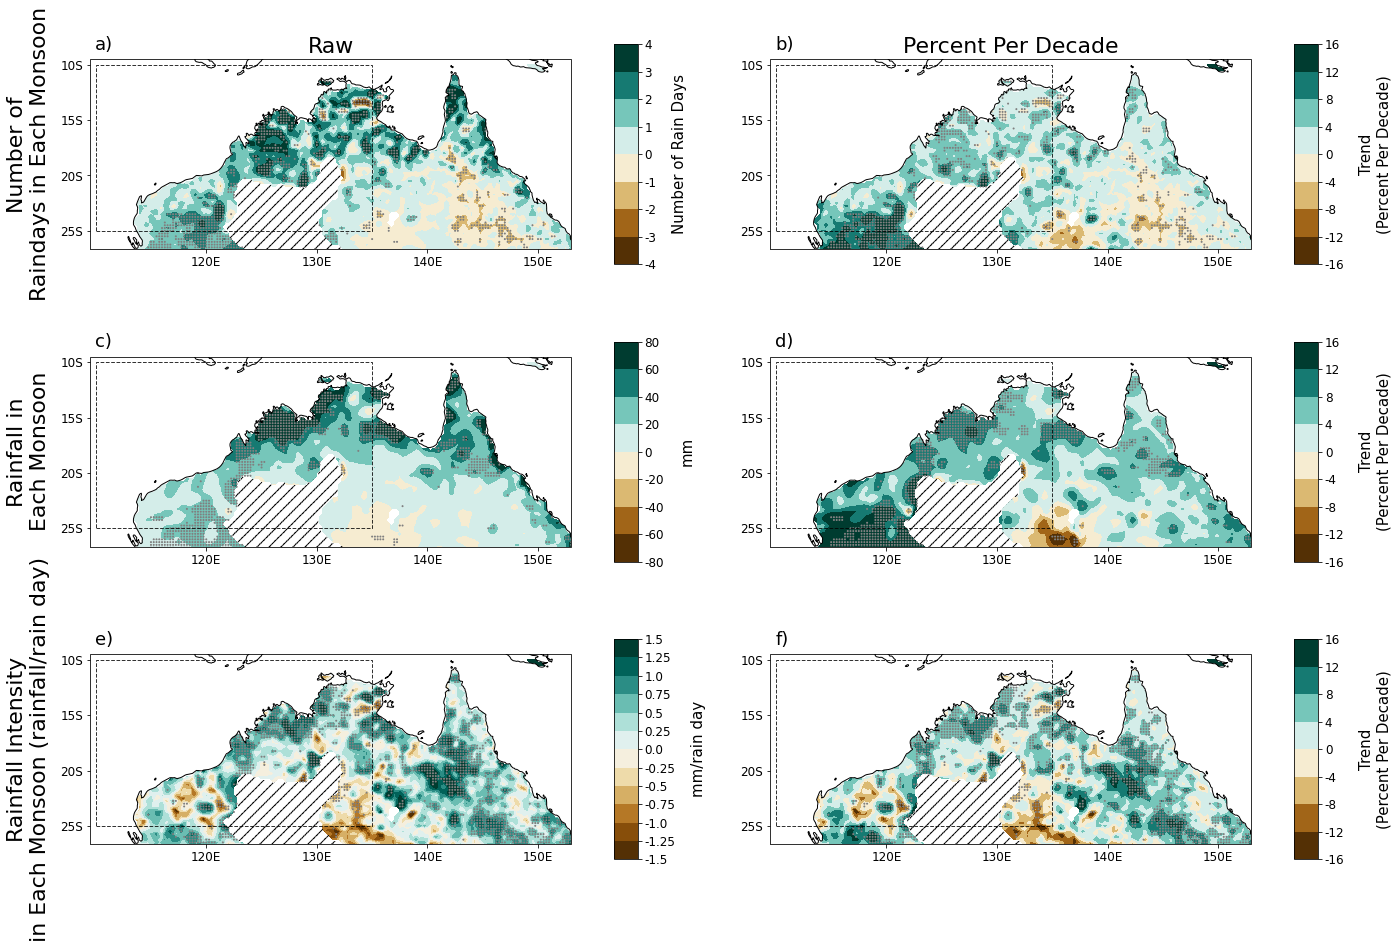

In [16]:
cmap='BrBG'

fig, gs =  pf.fig_formatter(height_ratios=[1]*len(data_set_list), width_ratios=[1, 0.05] + [0.1] + [1, 0.05], 
                           hspace=.35, wspace=.2)

plot_num = 0
for row_num, ds in enumerate(data_set_list):
    ax = fig.add_subplot(gs[row_num, 0], projection=ccrs.PlateCarree())
    levels = pf.create_levels(vmax=max_list[row_num], step=step_list[row_num])
    plot_raw = pf.nwa_map_plot(ds.trend * 10, ax, cmap=cmap, levels=levels,
                   stip_data=phase_calc.values_in_bounds(ds.pvals))
    ax.set_ylabel(format_name_string(names[row_num]), size=constants.title_size, labelpad=10)
    
    cax_raw = plt.subplot(gs[row_num, 1])
    pf.create_colorbar(plot_raw, cax_raw, levels,
                   orientation='vertical', rotation=0, title_rotation=90,
                  cbar_title=units[row_num], labelpad=15, round_level=round_levels[row_num])
    
    ax2 = fig.add_subplot(gs[row_num, 3], projection=ccrs.PlateCarree())
    levels_percent = pf.create_levels(vmax=16, step=4)
    plot_percent = pf.nwa_map_plot(ds.trend_percent, ax2, cmap=cmap, levels=levels_percent,
                   stip_data=phase_calc.values_in_bounds(ds.pvals))
    
    cax_percent = plt.subplot(gs[row_num, 4])
    pf.create_colorbar(plot_percent, cax_percent, levels_percent, ticks=levels_percent.astype(str), 
                       cbar_title= "Trend\n(Percent Per Decade)",
                   orientation='vertical', rotation=0, title_rotation=90, labelpad=15)
        
    if row_num==0:
        ax.set_title('Raw', size=constants.title_size)
        ax2.set_title('Percent Per Decade', size=constants.title_size)
        
    pf.add_figure_label(ax, f'{chr(97+row_num*2)})')
    pf.add_figure_label(ax2, f'{chr(97+row_num*2+1)})')
    
# fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR, '03_all_index_trends.png')
#             , dpi=600, bbox_inches='tight')

Text(0.5, 1.0, 'Number of Days in Enhanced MJO Phases')

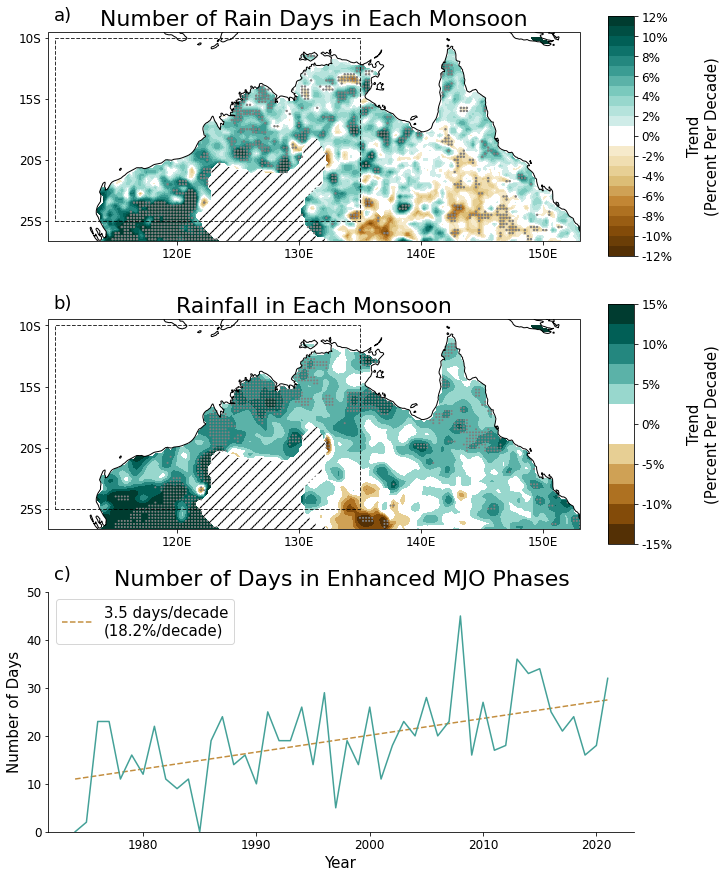

In [17]:
fig, gs = pf.fig_formatter(height_ratios=[1,1,1], width_ratios=[1, 0.05], hspace=0.2, wspace=0.1)


levels1 = pf.create_levels(vmax=12, step=1)
cmap1 = pf.create_discrete_cmap('BrBG', levels=levels1, add_white=True)

ax1 = fig.add_subplot(gs[0,0], projection = ccrs.PlateCarree())
plot1 = pf.nwa_map_plot(trend_count_ds.trend_percent, ax1, cmap1, levels1, sig_size=2,
    stip_data = phase_calc.values_in_bounds(trend_count_ds.pvals),
                        title = 'Number of Rain Days in Each Monsoon')

pf.add_figure_label(ax1, 'a)')

cax1 = plt.subplot(gs[0,1])
ticks1 = np.core.defchararray.add(levels1.astype(str)  , np.tile('%',len(levels1)))
pf.create_colorbar(plot1, cax1, levels1, ticks=ticks1[::2], cbar_title= "Trend\n(Percent Per Decade)",
                   orientation='vertical', rotation=0, cut_ticks=2, title_rotation=90,
                  labelpad=15)

levels2 = pf.create_levels(vmax=15, step=2.5)
cmap2 = pf.create_discrete_cmap('BrBG', levels=levels2, add_white=True)

ax2 = fig.add_subplot(gs[1,0], projection = ccrs.PlateCarree())
plot2 = pf.nwa_map_plot(trend_sum_ds.trend_percent, ax2, cmap2, levels2,
    stip_data = phase_calc.values_in_bounds(trend_sum_ds.pvals)
                        ,title = 'Rainfall in Each Monsoon')   

pf.add_figure_label(ax2, 'b)')

cax2 = plt.subplot(gs[1,1])
ticks2 = np.core.defchararray.add(levels2.astype(int).astype(str)  , np.tile('%',len(levels2)))
pf.create_colorbar(plot2, cax2, levels2,  ticks=ticks2[::2], cbar_title="Trend\n(Percent Per Decade)",
                   orientation='vertical', rotation=0, cut_ticks=2, title_rotation=90,
                  labelpad=15)

################ MJO Trend

phase = 'enhanced'

ax = fig.add_subplot(gs[2,:])

pf.mjo_single_phase_line_plot(ax, subphase_count.sel(phase = phase).number, trendline_color=constants.brown)

ax.set_ylim([0,50])
ax.set_xlabel('Year', size = constants.cbar_title_size)
ax.set_ylabel('Number of Days', size=constants.cbar_title_size)
ax.legend(loc='upper left', fontsize=constants.cbar_title_size)
pf.format_axis(ax)
pf.add_figure_label(ax, 'c)')
ax.set_title('Number of Days in Enhanced MJO Phases', size=constants.title_size)

# fig.savefig(os.path.join(image_dir, '03_final_total_trend_and_rmm_enhanced_trend.png'), dpi = 600
#            ,bbox_inches = 'tight', pad = 0)